# RespiCoV sequencing analysis by known sequence

Analyze fastq file(s) from nanopore sequencing output using known sequences to match against.

Run here on my first two RespiCoV sequencing attempts where I knew (from gel) that I had a lot of mis-priming and low read counts. Both attempts used 50-54 different samples divided into 8 different barcoded pools. The RC2 run

**Goals:**
 * Precisely identify target matches per input sample given known sequences
 * Run relatively quickly on a single machine and scale linearly with input sequence
 * Enable iterative exploration of the data (cache the most expensive operations)
 * Support multiple targets per sample (pooled samples)
 * Work with either ligration or tagmentation chemistry
 * Don't rely on precise primer-pair identification

**TODO:**
 * Look into unexpected matches - just barcode failure or possibly a different virus all together?
 
**Non-goals / future work elsewhere:**
 * Analyze mis-priming or PCR efficiency (see RCMatchPrimers).
 * Support more matching read than can fit into RAM at once

## Initialization and configuration

In [2]:
import random
from Bio.Seq import Seq
from Bio import SeqIO
import matplotlib_inline.backend_inline
import os
import pandas as pd
import RCUtils

%load_ext autoreload
%autoreload 1
%aimport RCUtils

# Get high-dpi output for retina displays
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

fastQBaseDirs = {
    "RC1": "../RespiCov-1/20221204_2344_MN41817_FAV39017_1bf37150/fastq_pass/",
    "RC2": "../RespiCov-2/20230430_1642_MN41817_APC888_8b249272/fastq_pass/"}

seqDir = "myseqs"

pd.options.display.max_rows = 50
pd.options.display.min_rows = 25

# Read in all the reference sequences
seqs = []
for file in sorted(filter(lambda f: f.endswith(".fastq"), os.listdir(seqDir))):  
    for seq in SeqIO.parse(os.path.join(seqDir, file), "fastq"):
        seqs.append(seq)
print("Read %i sequences" % (len(seqs)))


Read 3 sequences


## Process all the reads

In [3]:
import time

def getSeqMatches():
    for (sample, fastQDir) in RCUtils.getAllSampleDirs(fastQBaseDirs):
        print("Processing " + sample + ": ", end="")
        reads = 0
        start = time.process_time()
        matchingReads = []

        for read in RCUtils.getReads(fastQDir):
            reads += 1
            matches = RCUtils.seqMatch(read, seqs)
            if len(matches) > 0:
                matchingReads.append((read, matches))

        elapsed = time.process_time() - start
        print("  %i / %i reads, %.2fs" % (len(matchingReads), reads, elapsed))
        yield (sample, matchingReads)

# Store all the results in a list
seqMatches = list(getSeqMatches())
print("Processed %i samples" % len(seqMatches))

Processing RC1-barcode01:   0 / 647 reads, 2.05s
Processing RC1-barcode02:   1 / 692 reads, 2.11s
Processing RC1-barcode03:   16 / 436 reads, 1.61s
Processing RC1-barcode04:   0 / 624 reads, 1.90s
Processing RC1-barcode05:   0 / 682 reads, 2.12s
Processing RC1-barcode06:   26 / 771 reads, 2.68s
Processing RC1-barcode07:   17 / 809 reads, 2.71s
Processing RC1-barcode08:   0 / 894 reads, 2.49s
Processing RC2-barcode01:   0 / 502 reads, 2.19s
Processing RC2-barcode02:   0 / 240 reads, 0.98s
Processing RC2-barcode03:   0 / 369 reads, 1.52s
Processing RC2-barcode04:   35 / 251 reads, 1.48s
Processing RC2-barcode05:   0 / 179 reads, 0.72s
Processing RC2-barcode06:   0 / 341 reads, 1.44s
Processing RC2-barcode07:   4 / 408 reads, 1.72s
Processing RC2-barcode08:   71 / 299 reads, 2.09s
Processed 16 samples


## Dump the match details per target

In [4]:
from collections import defaultdict
import statistics

seqMatchesPerTarget = {}
for (sample, matchingReads) in seqMatches:
    perTarget = defaultdict(list)
    for (read, matches) in matchingReads:
        mr = matches[0].score / len(matches[0].target)
        mrdiff = mr
        if (len(matches) > 1):
            mrdiff = mr - (matches[1].score / len(matches[1].target))
        matchLen =abs(matches[0].targetEnd - matches[0].targetStart)
        perTarget[matches[0].target.id].append({"mr":mr, "mrdiff":mrdiff, "len": matchLen, "read":read, "match":matches[0]})
    if (len(perTarget) > 0):
        seqMatchesPerTarget[sample] = perTarget

table = {"Sample":[], "Target":[], "Matches":[], "Avg MR":[], "Avg MR Diff":[], "Avg Len":[]}
for (sample, perTarget) in seqMatchesPerTarget.items():
    for (target, matches) in perTarget.items():
        table["Sample"].append(sample)
        table["Target"].append(target)
        table["Matches"].append(len(matches))
        table["Avg MR"].append(round(statistics.median(map(lambda m: m["mr"], matches)), ndigits=2))
        table["Avg MR Diff"].append(round(statistics.median(map(lambda m: m["mrdiff"], matches)), ndigits=2))
        table["Avg Len"].append(int(statistics.median(map(lambda m: m["len"], matches))))
df = pd.DataFrame(data=table)
df.set_index(["Sample","Target"], inplace=True)
df

Matches  Avg MR  Avg MR Diff  Avg Len
Sample        Target                                           
RC1-barcode02 S28-RVA-23        1    0.42         0.12      181
RC1-barcode03 S28-RVA-23       16    0.81         0.23      391
RC1-barcode06 S44-RVA-56       26    0.79         0.15      415
RC1-barcode07 S48-RVC-1        16    0.79         0.38      395
              S44-RVA-56        1    0.82         0.15      396
RC2-barcode04 S48-RVC-1        34    0.85         0.40      395
              S28-RVA-23        1    0.85         0.24      373
RC2-barcode07 S28-RVA-23        4    0.79         0.22      384
RC2-barcode08 S44-RVA-56       12    0.79         0.13      391
              S28-RVA-23       59    0.83         0.23      389

All the results with more than 4 matches are as expected:
 * Rhinovirus A-23 in RC1-03 and again mixed in RC2-08
 * Rhinovirus A-56 in RC1-06 and again mixed in RC2-08
 * Rhinovirus C-1 in RC1-07 and in RC2-04

The match ratio (MR) seems to do a reasonably good job discriminating - at least 13pp difference between RVA-23 and RVA-56. RVC-1 is, as expected, always more distant - around 40pp.

The expected match length for the Rhinovirus primers is 395bp, most are quite close. 

The results with 4 or fewer matches are unexpected. Let's look into them.

In [5]:
from matplotlib import pyplot as plt

sampleMatches = dict(seqMatches)

def dumpTargetMatches(sample, target):
    table = {"Target":[], "Score":[], "Len":[], "Target 2":[], "Score 2":[]}
    for (read, matches) in sampleMatches[sample]:
        if (matches[0].target.id == target):
            target2 = ""
            score2 = ""
            if (len(matches) > 1):
                target2 = matches[1].target.id
                score2 = int(matches[1].score)
            matchLen =abs(matches[0].targetEnd - matches[0].targetStart)
            table["Target"].append(target)
            table["Score"].append(int(matches[0].score))
            table["Len"].append(matchLen)
            table["Target 2"].append(target2)
            table["Score 2"].append(score2)
    display(pd.DataFrame(data=table))

def targetMatchScoreHist(sample, target):
    scores = []
    for (read, matches) in sampleMatches[sample]:
        if (matches[0].target.id == target):
            scores.append(matches[0].score)
    plt.hist(scores, bins=20)
    plt.title("%s %s Match Scores" % (sample, target))
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.show()

def printSpecificReadSeq(sample, target):
    matchInfo = max(seqMatchesPerTarget[sample][target], key=lambda m: m["mr"])
    print(">%s %s %.0f%%" % (sample, target, matchInfo["mr"] * 100))
    print(matchInfo["read"][matchInfo["match"].readStart:matchInfo["match"].readEnd].seq)

def printMatchSeq(sample, target, matchidx):
    matchingReads = sampleMatches[sample]
    (read, hits) = list(filter(lambda mr: mr[1][0].target.id == target, matchingReads))[matchidx] 
    print(">%s %s score=%i" % (sample, target, hits[0].score))
    print(read[hits[0].readStart:hits[0].readEnd].seq)

## What's with the RC1-barcode02 result?
Is it just a barcode failure?

In [6]:
dumpTargetMatches("RC1-barcode02", "S28-RVA-23")

printSpecificReadSeq("RC1-barcode02", "S28-RVA-23")
printSpecificReadSeq("RC1-barcode03", "S28-RVA-23")

,Target,Score,Len,Target 2,Score 2
0,S28-RVA-23,163,181,S44-RVA-56,125


>RC1-barcode02 S28-RVA-23 42%
AACACGGACACCAAAGTAGTTGGTCCCATCCCGCAATTGCTCGTTACGACTAGAAACACTGGATTGTGCGCTCTAGCTGCAGGGTTAAGGTTAGCCACATTCGGGGGCCGGGAGGACTCAAAGCGACACACGGGGCTCTTCACACCCTATCCATTGTATGGCTTCACACCCAGAGGGT
>RC1-barcode03 S28-RVA-23 91%
AACACGGACACCCAAAGTAGTTGGTCCCATCCCGCAATTGCTCGTTACGACTAGAGAAACACACTGGATTGTGCGCTCTAGCTGCAGGGATTTGAGTTAGCCACATTCCAGGGGCCGGAGGACTCAAAGCGAGCACACGGGGCTCTTCACACCCTGTCCATTGTATGGCTTCACACCCAGAGGGTGTGCAGGCAGCCACGCAGGCTAGAACACTGTCGCCAGTGGGGAGTTTCTAGCCTCTGGCTCTGCCAGGTCTACCAGGGGGAATGGTGGAGCGACCAGCCAGACAACTTCCAGAGTACTACTAAGCTTTGCGTAGGCGCTTTGCGGATAACGATCGCAGCTGTTTTTGCCCTGGTGGGGCATATCAACTTTGACCGGGGAAACAGGAG


The match is unsually short, but the score is pretty close to the length. Doing a blast for these sequences we can see that it's indeed both RV-A23, but the first is truncated, only the last half.

## What's the variance on a good match like RC1-barcode06?

,Target,Score,Len,Target 2,Score 2
0,S44-RVA-56,337,415,S28-RVA-23,260
1,S44-RVA-56,348,415,S28-RVA-23,273
2,S44-RVA-56,346,417,S28-RVA-23,266
3,S44-RVA-56,364,415,S28-RVA-23,278
4,S44-RVA-56,321,415,S28-RVA-23,256
5,S44-RVA-56,329,415,S28-RVA-23,243
6,S44-RVA-56,218,415,S28-RVA-23,156
7,S44-RVA-56,340,394,S28-RVA-23,267
8,S44-RVA-56,336,415,S28-RVA-23,254
9,S44-RVA-56,306,392,S28-RVA-23,242


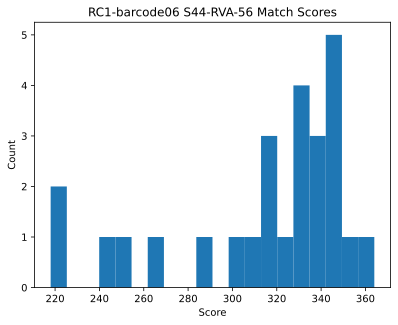

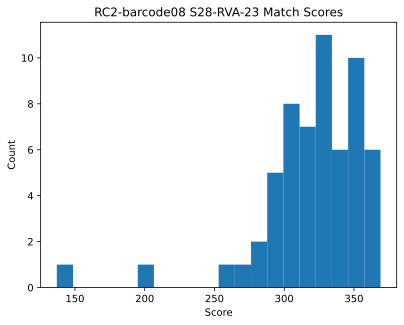

In [7]:
dumpTargetMatches("RC1-barcode06", "S44-RVA-56")
targetMatchScoreHist("RC1-barcode06", "S44-RVA-56")
targetMatchScoreHist("RC2-barcode08", "S28-RVA-23")

## What's with the 4 RC2-07 results

In [8]:
dumpTargetMatches("RC2-barcode07", "S28-RVA-23")

for i in range(0,4):
    printMatchSeq("RC2-barcode07", "S28-RVA-23", i)


,Target,Score,Len,Target 2,Score 2
0,S28-RVA-23,308,378,S44-RVA-56,235
1,S28-RVA-23,364,390,S44-RVA-56,280
2,S28-RVA-23,314,391,S44-RVA-56,241
3,S28-RVA-23,175,232,S28-RVA-23,168


>RC2-barcode07 S28-RVA-23 score=308
TCAAGCACTTCTGTTTCCCAGTCCAAAGTTGATATACCCCACCAGGGCAAAAACAGCTGCGATCGTTATCCGCAAAGCGCCTACGCAAAGCTTAGTAGTACTCCTGAAGTTGTCTGGCTGGTCGCTCCACCATTCCCCCTGGTAGACCTGGCAGATGAGGCTTAGAAACTCCCCACTGGCGACAGTGTTCTAGCCTGCGTGGCTACTGCACACCCTCTGGGTGTGAAGCCATGCAATGGACAGGGTGTGAAGAGCTTGTGTGCTCGCTTTTTGAGTCCTCAACTAATTGTGGCTAACCTTAACCCTGCAGCTAGAGCACACAATCCAGTGTGTTTCTAGTCATGTGGTAATTGCGGGATGGGACCAACTACTTT
>RC2-barcode07 S28-RVA-23 score=364
CAAGCACTTCTGTTTCCCCGGTCAAAGTTGATATGCCCCACCAGGGCAAAGCAGCTGCGATCGTTGTCGCAAAGCGCCTACGCAAAGCTTAGTAGTACTCTGGAAGTTGTCTGGCTGGTCGCTCCACCATTCCCCCTGGTGAGCCTGGCAGATGAGGCTAAAAACTCCCACTGGCGACAGTGTTCTGGCCTGCGTGGCTGCCTGCACACCCTCTGGGTGTGAAGCCATACAATGGACAGGGTGTGAAGAGCCCCGTGTGCTCGCTTTGGAGTCCTCCGGCCCCTGAATGTGGCTAACCTTAACCCTGCAGCTAGAGCGCACAATCCAGTGTGTTTCTAGTCGTAACGAGCAATTGCGGGATGGGACCAACTACTTTGGGTGTCCGTGTT
>RC2-barcode07 S28-RVA-23 score=314
TCAAGCACTTCTGTTTCCCCGGTCAAAGTTGATATGCCCCACCGGGGCAAAAACAGCTGCGATCGTTATCCGCAAAGCGCCTACGCAAAGCTTAGTAGTACTCTGGAAGTTGTCTGGCTGGTCGCTC

From Blast, these all look like legit A-23 hits. Probably just barcode cross-talk or maybe contamination. Or maybe it's possible that S27 also has some of the same virus as S28?

The last one has a chunk of a reverse-complement match concatenated with a truncated match. I'd like to visualize this better. Where are the primers? 

## Summarize the true hits

In [9]:
table = {"Sample":[], "Target":[], "Matches":[], "Avg MR":[], "Avg MR Diff":[], "Avg Len":[]}
for (sample, perTarget) in seqMatchesPerTarget.items():
    for (target, matches) in perTarget.items():
        if len(matches) > 5:
            table["Sample"].append(sample)
            table["Target"].append(target)
            table["Matches"].append(len(matches))
            table["Avg MR"].append(round(statistics.median(map(lambda m: m["mr"], matches)), ndigits=2))
            table["Avg MR Diff"].append(round(statistics.median(map(lambda m: m["mrdiff"], matches)), ndigits=2))
            table["Avg Len"].append(int(statistics.median(map(lambda m: m["len"], matches))))
df = pd.DataFrame(data=table)
df.set_index(["Sample","Target"], inplace=True)
df

Matches  Avg MR  Avg MR Diff  Avg Len
Sample        Target                                           
RC1-barcode03 S28-RVA-23       16    0.81         0.23      391
RC1-barcode06 S44-RVA-56       26    0.79         0.15      415
RC1-barcode07 S48-RVC-1        16    0.79         0.38      395
RC2-barcode04 S48-RVC-1        34    0.85         0.40      395
RC2-barcode08 S44-RVA-56       12    0.79         0.13      391
              S28-RVA-23       59    0.83         0.23      389